In [1]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import log_loss

CONST_FEATURE = 5
CONST_INTERVAL = 50

In [2]:
df = pd.read_json("./train.json")
df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


In [3]:
df2 = pd.read_json("./test.json")
df2.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street


In [4]:
#handle outliners
#bathroom
df = df.loc[ (df['bathrooms'] > 0) & (df['bathrooms'] != 10)]
z_bath = np.abs(stats.zscore(df['bathrooms']))
df = df[(z_bath < 3)]

#bedroom
z_bed = np.abs(stats.zscore(df['bedrooms']))
df = df[(z_bed < 3)]

#latitude
df = df.loc[
    (df['latitude'] >= 19.50139) & 
    (df['latitude'] <= 64.85694)
    ]
z_lati = np.abs(stats.zscore(df['latitude']))
df = df[(z_lati < 3)]

#longitude
df = df.loc[
    (df['longitude'] >= -161.75583) & 
    (df['longitude'] <= -68.01197)
    ]
z_long = np.abs(stats.zscore(df['longitude']))
df = df[(z_long < 3)]

#price
z_price = np.abs(stats.zscore(df['price']))
df = df[(z_price < 3)]

df = df[(df['description'] != '') & (df['description'] != '<p><a  website_redacted')]
df = df[df['display_address'] != '']
df = df[df['features'].str.len() > 0]
df = df[(df['interest_level'] == 'low') | (df['interest_level'] == 'medium') | (df['interest_level'] == 'high')]

df = df[df['latitude'] != 0]
df = df[df['longitude'] != 0]
df = df[df['photos'].str.len() > 0]
df = df[df['street_address'].str.len() > 0]

df.shape

(40729, 15)

In [5]:
#convert 'price' to categorical attributes
indexes = list(df.index.values.tolist())
price = list(df['price'][indexes])

price_list = []
for i in range(len(price)):
    price_list.append(price[i])
price_list.sort()
price_list1 = list(dict.fromkeys(price_list))

interval_num = 0
if(len(price_list1) % CONST_INTERVAL ==0):
    interval_num = len(price_list1) / CONST_INTERVAL
else:
    interval_num = math.floor(len(price_list1) / CONST_INTERVAL) + 1

interval_num = int(interval_num)

price_interval = [[0 for x in range(2)] for y in range(interval_num)] 
counter = 0
label = 1
price_interval[0][0] = price_list1[0]
price_interval[0][1] = 0
for i in range(len(price_list1)):
    if(counter == CONST_INTERVAL):
        counter = 0
        price_interval[label][0] = price_list1[i]
        price_interval[label][1] = label
        label += 1
    else:
        counter += 1
        
#print(price_interval)
price_category = []
for i in range(len(price)):
    for j in range(len(price_interval)):
        if(price[i] < price_interval[j][0]):
            price_category.append(price_interval[j][1]-1)
            break
        elif(j == (len(price_interval)-1)):
            price_category.append(price_interval[j][1])
            break
    
df.insert(12, "price_category", price_category, True) 
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,6,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,22,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,19,3495,405 East 56th Street,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,10,2795,340 East 34th Street,low
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,43,7200,145 East 16th Street,low


In [6]:
#convert 'price' to categorical attributes
indexes_t = list(df2.index.values.tolist())
price_t = list(df2['price'][indexes_t])

price_list_t = []
for i in range(len(price_t)):
    price_list_t.append(price_t[i])
price_list_t.sort()
price_list1_t = list(dict.fromkeys(price_list_t))

interval_num_t = 0
if(len(price_list1_t) % CONST_INTERVAL ==0):
    interval_num_t = len(price_list1_t) / CONST_INTERVAL
else:
    interval_num_t = math.floor(len(price_list1_t) / CONST_INTERVAL) + 1

interval_num_t = int(interval_num_t)

price_interval_t = [[0 for x in range(2)] for y in range(interval_num_t)] 
counter = 0
label = 1
price_interval_t[0][0] = price_list1_t[0]
price_interval_t[0][1] = 0
for i in range(len(price_list1_t)):
    if(counter == CONST_INTERVAL):
        counter = 0
        price_interval_t[label][0] = price_list1_t[i]
        price_interval_t[label][1] = label
        label += 1
    else:
        counter += 1
        
#print(price_interval)
price_category_t = []
for i in range(len(price_t)):
    for j in range(len(price_interval_t)):
        if(price_t[i] < price_interval_t[j][0]):
            price_category_t.append(price_interval_t[j][1]-1)
            break
        elif(j == (len(price_interval_t)-1)):
            price_category_t.append(price_interval_t[j][1])
            break
    
df2.insert(12, "price_category", price_category_t, True) 
df2.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,16,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,15,2850,176 Thompson Street
2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,7,2295,115 Sullivan Street
3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,15,2900,23 Jones Street
5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,Exchange Place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,21,3254,20 Exchange Place


In [7]:
#convert 'created' to numerical attributes
#this step will take about 1min to process
indexes = list(df.index.values.tolist())
time = list(df['created'][indexes])

new_time = []
for i in range(len(time)):
    new_time.append(time[i])
new_time.sort()
new_time1 = list(dict.fromkeys(new_time))

interval_leng = 0
if(len(new_time1) % CONST_INTERVAL ==0):
    interval_leng = len(new_time1) / CONST_INTERVAL
else:
    interval_leng = math.floor(len(new_time1) / CONST_INTERVAL) + 1
    
time_interval = [[0 for x in range(2)] for y in range(interval_leng)] 
counter = 0
label = 1
time_interval[0][0] = new_time1[0]
time_interval[0][1] = 0
for i in range(len(new_time1)):
    if(counter == CONST_INTERVAL):
        counter = 0
        time_interval[label][0] = new_time1[i]
        time_interval[label][1] = label
        label += 1
    else:
        counter += 1
        
create_time = []
for i in range(len(time)):
    for j in range(len(time_interval)):
        if(time[i] < str(time_interval[j][0])):
            create_time.append(time_interval[j][1]-1)
            break
        elif(j == (len(time_interval)-1)):
            create_time.append(time_interval[j][1])
            break
            
df.insert(4, "create time interval", create_time, True) 
df.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,674,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,6,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,528,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,22,3800,230 East 44th,low


In [8]:
#convert 'created' to categorical attributes(for test.json)
#this step will take about 1min to process
indexes_t = list(df2.index.values.tolist())
time_t = list(df2['created'][indexes_t])

new_time_t = []
for i in range(len(time_t)):
    new_time_t.append(time_t[i])
new_time_t.sort()
new_time_t1 = list(dict.fromkeys(new_time_t))

interval_leng_t = 0
if(len(new_time_t1) % CONST_INTERVAL ==0):
    interval_leng_t = len(new_time_t1) / CONST_INTERVAL
else:
    interval_leng_t = math.floor(len(new_time_t1) / CONST_INTERVAL) + 1
    
time_interval_t = [[0 for x in range(2)] for y in range(interval_leng_t)] 
counter_t = 0
label_t = 1
time_interval_t[0][0] = new_time_t1[0]
time_interval_t[0][1] = 0
for i in range(len(new_time_t1)):
    if(counter_t == CONST_INTERVAL):
        counter_t = 0
        time_interval_t[label_t][0] = new_time_t1[i]
        time_interval_t[label_t][1] = label_t
        label_t += 1
    else:
        counter_t += 1
        
create_time_t = []
for i in range(len(time_t)):
    for j in range(len(time_interval_t)):
        if(time_t[i] < str(time_interval_t[j][0])):
            create_time_t.append(time_interval_t[j][1]-1)
            break
        elif(j == (len(time_interval_t)-1)):
            create_time_t.append(time_interval_t[j][1])
            break
            
df2.insert(4, "create time interval", create_time_t, True) 
df2.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,1130,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,16,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,1351,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,15,2850,176 Thompson Street


In [9]:
#tokenize 'features' then create vector
#from milestone 1
indexes = list(df.index.values.tolist())
values = list(df['features'][indexes])
text_list = []
holder = 0
for i in range(len(values)):
    for ele in values[i]:
        if(len(ele)>50):
            temp = []
            temp = re.split(r'[**]', ele)
            for j in range(len(temp)):
                text_list.append(temp[j])  
        else:
            text_list.append(ele)
        holder += 1 
        
#milestone 2
freq_word = Counter(text_list).most_common(CONST_FEATURE)
freq_count = []

for i in range(len(values)):
    freq = 0
    for ele in values[i]:
        #print(ele)
        for word in freq_word:
            if(word[0] == ele):
                #print('yes')
                freq += 1
    freq_count.append(freq)
#print(freq_count)

df.insert(7, "common word count", freq_count, True) 
df.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,common word count,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,674,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,4,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,6,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,528,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,3,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,22,3800,230 East 44th,low


In [10]:
#tokenize 'features' then create vector(for test.json)
#from milestone 1
indexes_t = list(df2.index.values.tolist())
values_t = list(df2['features'][indexes_t])
text_list_t = []
holder_t = 0
for i in range(len(values_t)):
    for ele in values_t[i]:
        if(len(ele)>50):
            temp_t = []
            temp_t = re.split(r'[**]', ele)
            for j in range(len(temp_t)):
                text_list_t.append(temp_t[j])  
        else:
            text_list_t.append(ele)
        holder_t += 1 
        
#milestone 2
freq_word_t = Counter(text_list_t).most_common(CONST_FEATURE)
freq_count_t = []

for i in range(len(values_t)):
    freq_t = 0
    for ele in values_t[i]:
        #print(ele)
        for word in freq_word_t:
            if(word[0] == ele):
                #print('yes')
                freq_t += 1
    freq_count_t.append(freq_t)
#print(freq_count)

df2.insert(7, "common word count", freq_count_t, True) 
df2.head(2)

,bathrooms,bedrooms,building_id,created,create time interval,description,display_address,common word count,features,latitude,listing_id,longitude,manager_id,photos,price_category,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,1130,Large with awesome terrace--accessible via bed...,Suffolk Street,2,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,16,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,1351,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,2,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,15,2850,176 Thompson Street


# 1. First Classifier 

use simple Cross-validation, and DecisionTreeClassifier without pruning

In [11]:
df_x = df[['bathrooms',
           'bedrooms',
           'price_category',
           'common word count',
           'create time interval']]

df_y = df[['interest_level']]

In [12]:
df_x_t = df2[['bathrooms',
           'bedrooms',
           'price_category',
           'common word count',
           'create time interval']]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    df_x, 
    df_y, 
    stratify = df_y, 
    test_size = 0.33, 
    random_state = 1)

In [14]:
clf = BernoulliNB()
my_clf = clf.fit(x_train, y_train)

print(f'Train_data_accuracy:{my_clf.score(x_train, y_train)}')
print(f'Validation_data_accuracy:{my_clf.score(x_test, y_test)}')

Train_data_accuracy:0.6734095573145705
Validation_data_accuracy:0.6736105944498177


/home/zhilin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
proba_list = my_clf.predict_proba(df_x_t)

high_p = []
med_p = []
low_p = []
for i in range(len(proba_list)):
    high_p = proba_list[i][0]
    med_p = proba_list[i][1]
    low_p = proba_list[i][2]
    
first_test_df = df2[['listing_id']]
first_test_df.insert(1, 'high',high_p, True) 
first_test_df.insert(2, 'medium',med_p, True) 
first_test_df.insert(3, 'low',low_p, True)

In [16]:
compression_opts = dict(method='zip',
                        archive_name='out1.csv')  
first_test_df.to_csv('first_try.zip', index=False,
          compression=compression_opts) 

# 2. Improvment

In [17]:
new_df_x = df[['bathrooms', 
               'bedrooms', 
               'price_category', 
               'create time interval']]

new_df_y = df[['interest_level']]

new_df_x_t = df2[['bathrooms',
                  'bedrooms',
                  'price_category',
                  'create time interval']]

In [18]:
#convert 'common word count' of train dataset 
#into several binary features

word_matrix = [[0 for x in range(CONST_FEATURE)] for y in range(len(values))] 

for i in range(len(values)):
    for j in range(CONST_FEATURE):
        for ele in values[i]:
            if(freq_word[j][0] == ele):
                word_matrix[i][j] = 1

for i in range(CONST_FEATURE):
    word_list = []
    for j in range(len(values)):  
        word_list.append(word_matrix[j][i])
    new_df_x.insert(i+4, i, word_list, True) 

In [19]:
#convert 'common word count' of test dataset 
#into several binary features

word_matrix_t = [[0 for x in range(CONST_FEATURE)] for y in range(len(values_t))] 

for i in range(len(values_t)):
    for j in range(CONST_FEATURE):
        for ele in values_t[i]:
            if(freq_word_t[j][0] == ele):
                word_matrix_t[i][j] = 1

for i in range(CONST_FEATURE):
    word_list_t = []
    for j in range(len(values_t)):  
        word_list_t.append(word_matrix_t[j][i])
    new_df_x_t.insert(i+4, i, word_list_t, True) 

In [20]:
#L1-based feature selection 
from sklearn.feature_selection import SelectFromModel
clf2 = BernoulliNB().fit(new_df_x, new_df_y)
model = SelectFromModel(clf2, prefit=True)
final_x =  model.transform(new_df_x)
final_x.shape

/home/zhilin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(40729, 5)

In [21]:
#use Stratified k-fold for Cross-Validation
skf = StratifiedKFold(n_splits = 5)

for train_index, test_index in skf.split(final_x, new_df_y):
    new_x_train, new_x_test =  new_df_x.iloc[train_index], new_df_x.iloc[test_index]
    new_y_train, new_y_test = new_df_y.iloc[train_index], new_df_y.iloc[test_index]
    
new_y_train.shape

(32584, 1)

In [22]:
#improved classifier
clf = BernoulliNB(alpha=1.0,
                  binarize = 0.0,
                  class_prior=None, 
                  fit_prior=True)

improved_clf = clf.fit(new_x_train, new_y_train)

print(f'Train_data_accuracy:{improved_clf.score(new_x_train, new_y_train)}')
print(f'Validation_data_accuracy:{improved_clf.score(new_x_test, new_y_test)}')

Train_data_accuracy:0.6742266142892217
Validation_data_accuracy:0.6747697974217312


/home/zhilin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix with normalization
[[0.02643857 0.97356143 0.        ]
 [0.00109389 0.99890611 0.        ]
 [0.00594943 0.99405057 0.        ]]


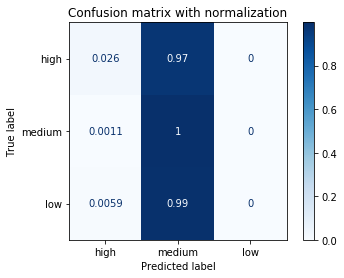

In [23]:
#confusion matrix
titles_options = [("Confusion matrix with normalization", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(estimator = improved_clf, 
                                 X = new_x_test, 
                                 y_true = new_y_test,
                                 display_labels=['high','medium','low'],
                                 cmap=plt.cm.Blues,
                                 normalize= 'true')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [24]:
#logarithmic loss
predict_list = improved_clf.predict_proba(new_x_test)
log_loss(new_y_test, predict_list)

0.8078372061590404

In [25]:
proba_list = improved_clf.predict_proba(new_df_x_t)

high_p = []
med_p = []
low_p = []
for i in range(len(proba_list)):
    high_p = proba_list[i][0]
    med_p = proba_list[i][1]
    low_p = proba_list[i][2]
    
final_test_df = df2[['listing_id']]
final_test_df.insert(1, 'high',high_p, True) 
final_test_df.insert(2, 'medium',med_p, True) 
final_test_df.insert(3, 'low',low_p, True)

In [26]:
compression_opts = dict(method='zip',
                        archive_name='out2.csv')  
final_test_df.to_csv('prediction_improved_classifier.zip', index=False,
          compression=compression_opts) 